In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("assets/cardio_train.csv", sep = ";").drop(columns = "id")

print(df.shape)
df.head()

(70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df["age"] = df["age"] // 365

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


# Disease Representation (2 A)

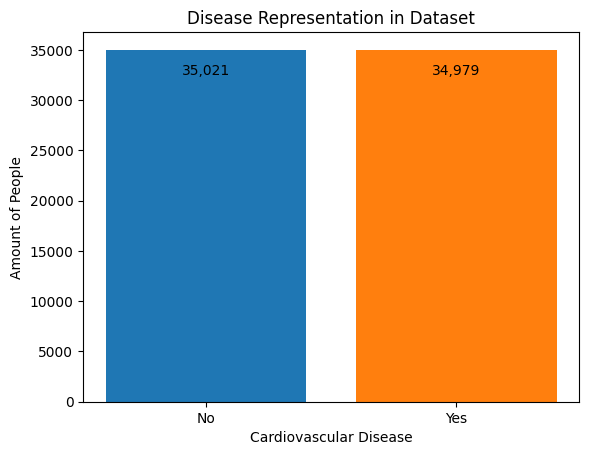

In [4]:
disease = {"No": 0, "Yes": 1}

fig, ax = plt.subplots() 

for i in disease.values(): # plot amount of each cardio value (0, 1) in df
    plt.bar(x = i, height = len(df[df["cardio"] == i]))

# set amount and position of ticks based on values, and map keys to them
plt.xticks(ticks = [value for value in disease.values()], labels = disease.keys())

for p in ax.containers: # show and format values on bars
    ax.bar_label(p, labels = [f"{val:,.0f}" for val in p.datavalues], padding = -20)

# set labels
ax.set(title = "Disease Representation in Dataset", xlabel = "Cardiovascular Disease", ylabel = "Amount of People");

# Cholesterol Levels (2 B)

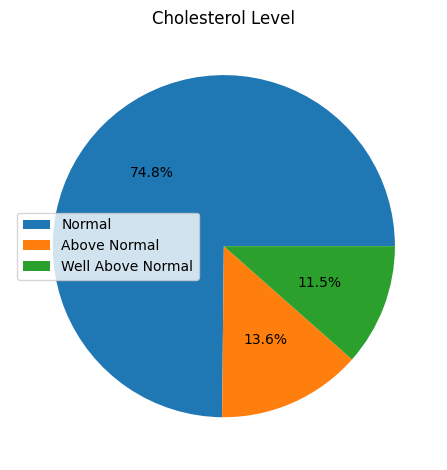

In [5]:
cholesterol = {"Normal": 1, "Above Normal": 2, "Well Above Normal": 3}

fig, ax = plt.subplots()

# plot amount of each cholesterol value (1, 2, 3) in df
plt.pie(x = [len(df[df["cholesterol"] == i]) for i in cholesterol.values()], autopct=lambda pct: f"{pct:.1f}%")

# map keys to legend
plt.legend(cholesterol.keys())

# set labels
ax.set(title = "Cholesterol Level")

plt.tight_layout()

# Age Distribution (2 C)

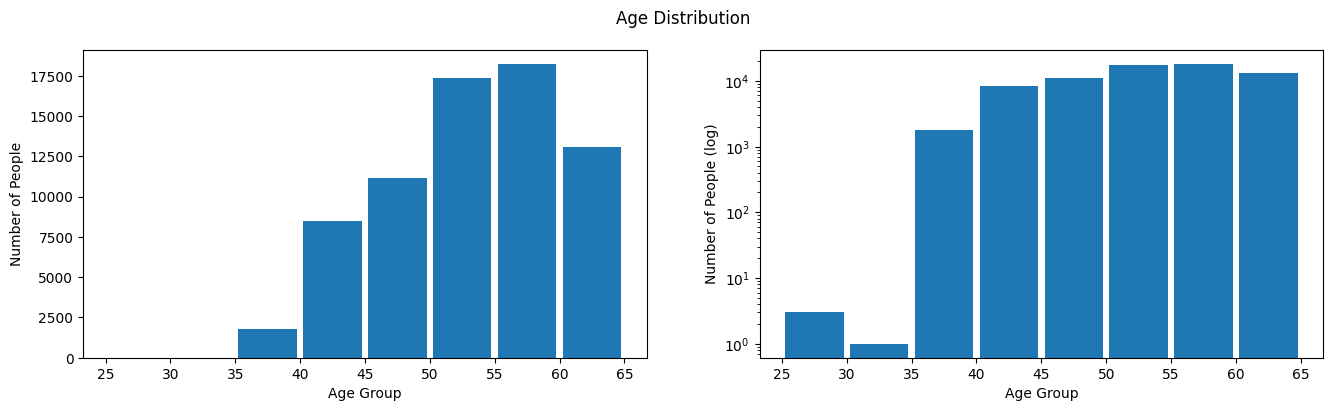

In [6]:
# pick out age groups between lowest and highest age in dataset
step = 5 # group size of bins (amount of years to group together)
start = (min(df["age"]) // step) * step # nearest multiple of [step] below min age
stop = (max(df["age"]) // step) * step + step # nearest multiple of [step] below max age, +[step] to get nearest multiple of [step] above max
bins = [i for i in range(start, stop+1, step)] # create bins list, +1 to be inclusive of last value

fig, axes = plt.subplots(1, 2, figsize = (16, 4))

# plot age grouped by bins, one normal and one log
for ax, log in zip(axes.flatten(), [False, True]):
    ax.hist(df["age"].values, bins, rwidth = 0.9, log = log) # rwidth <1 for space between bins
    ax.set(xlabel = "Age Group", ylabel = "Number of People" if log == False else "Number of People (log)") # set ylabel to reflect log state

fig.suptitle("Age Distribution");

# Smokers (2 D)

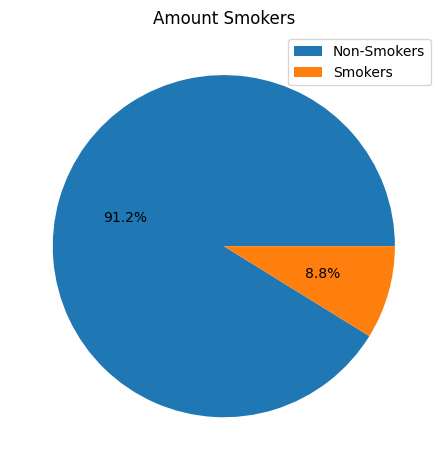

In [7]:
smoker = {"Non-Smokers": 0, "Smokers": 1}

fig, ax = plt.subplots()


# plot amount of each smoker value (0, 1) in df
plt.pie(x = [len(df[df["smoke"] == i]) for i in smoker.values()], autopct=lambda pct: f"{pct:.1f}%")

# map keys to legend
plt.legend(smoker.keys())

# set labels
ax.set(title = "Amount Smokers")

plt.tight_layout()

# Weight Distribution (2 E)

### Distplot with KDE

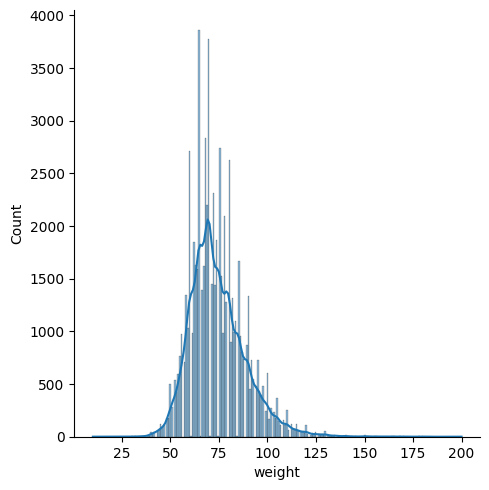

In [8]:
sns.displot(df["weight"], kde = True);

### Violinplot showing outliers

In [9]:
Q1 = df["weight"].quantile(0.25)
Q3 = df["weight"].quantile(0.75)
IQR = Q3 - Q1

# seaborn / Tukey's boxplot definition of outliers
outlier_lower = Q1 - 1.5 * IQR
outlier_upper = Q3 + 1.5 * IQR

outlier_lower, outlier_upper

(39.5, 107.5)

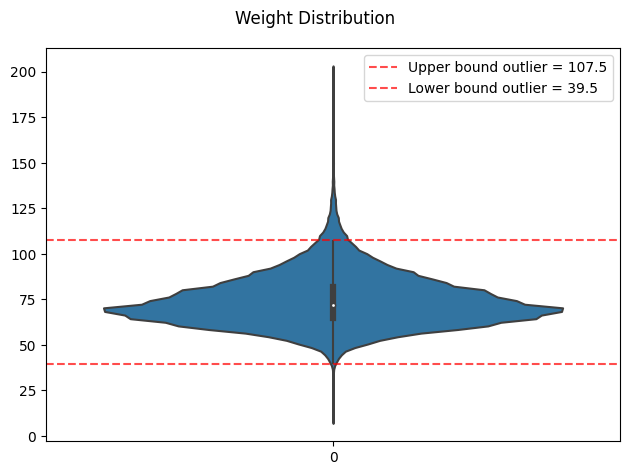

In [10]:
sns.violinplot(df["weight"])
plt.axhline(y = outlier_upper, label = f"Upper bound outlier = {outlier_upper}", color = "r", linestyle = "--", alpha = 0.7)
plt.axhline(y = outlier_lower, label = f"Lower bound outlier = {outlier_lower}", color = "r", linestyle = "--", alpha = 0.7)
plt.legend()
plt.suptitle("Weight Distribution")
plt.tight_layout()

# Height Distribution (2 F)

### Distplot with KDE

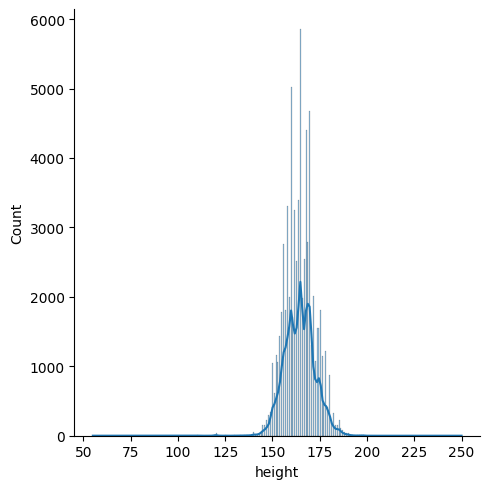

In [11]:
sns.displot(df["height"], kde = True);

### Violinplot showing outliers

In [12]:
Q1 = df["height"].quantile(0.25)
Q3 = df["height"].quantile(0.75)
IQR = Q3 - Q1

# seaborn / Tukey's boxplot definition of outliers
outlier_lower = Q1 - 1.5 * IQR
outlier_upper = Q3 + 1.5 * IQR

outlier_lower, outlier_upper

(142.5, 186.5)

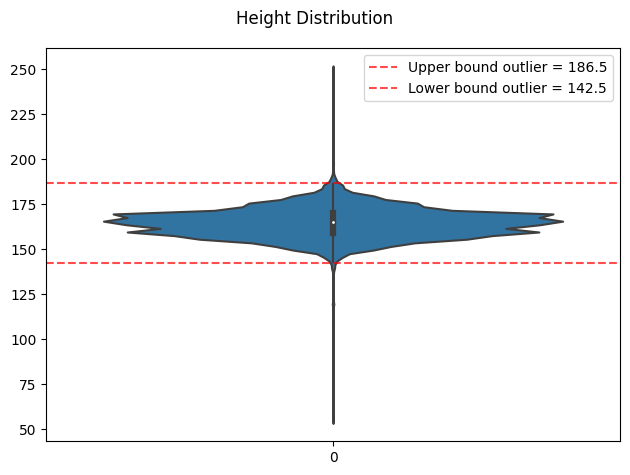

In [13]:
sns.violinplot(df["height"])
plt.axhline(y = outlier_upper, label = f"Upper bound outlier = {outlier_upper}", color = "r", linestyle = "--", alpha = 0.7)
plt.axhline(y = outlier_lower, label = f"Lower bound outlier = {outlier_lower}", color = "r", linestyle = "--", alpha = 0.7)
plt.legend()
plt.suptitle("Height Distribution")
plt.tight_layout()

# Disease by Sex (2 G)

### Amount of people with cardiovascular disease

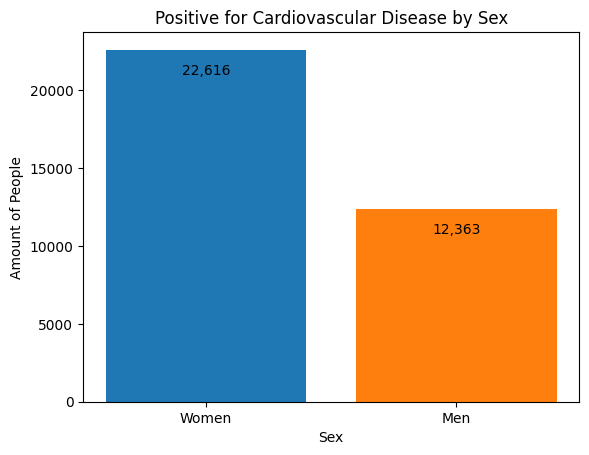

In [14]:
fig, ax = plt.subplots()

genders = {"Women": 1, "Men": 2} # dictionary with key "Gender" and value the corrsesponding number in dataset

# loop over genders
for i in genders:
    # filter out amount of datapoints where gender = gender and cardio = True
    filter = len(df[(df["gender"] == genders[i]) & (df["cardio"] == 1)])
    # plot bar under gender with height = amount of matching datapoints
    plt.bar(x = i, height = filter)

for p in ax.containers: # show and format values on bars
    ax.bar_label(p, labels = [f"{val:,.0f}" for val in p.datavalues], padding = -20)

# set labels
ax.set(title = "Positive for Cardiovascular Disease by Sex", xlabel = "Sex", ylabel = "Amount of People");

### Percentage of people with cardiovascular disease (by sex)

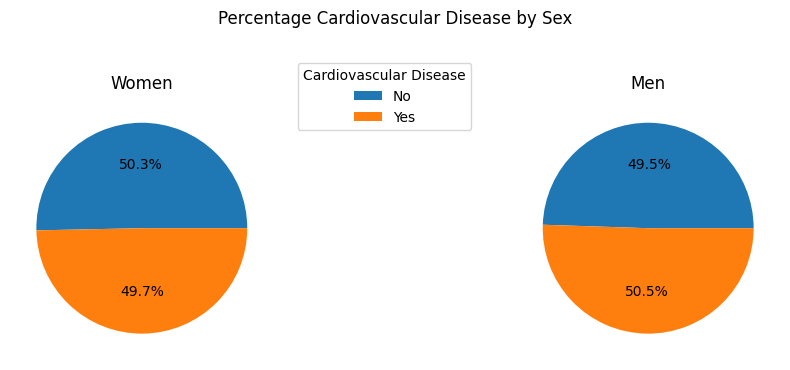

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4))

# loop over gender and axes
for i, ax in zip(genders, axes.flatten()):
    # use gender values to get disease data based on gender
    total = len(df[df["gender"] == genders[i]]) # amt people in dataset
    disease = len(df[(df["gender"] == genders[i]) & (df["cardio"] == 1)]) # amt with cardiovascular
    healthy = total - disease # amt without cardiovascular

    # plot gender values in current ax
    ax.pie(x = [i for i in [healthy, disease]], autopct=lambda pct: f"{pct:.1f}%")
    ax.set_title(i) # set title based on gender key

# show legend, position in center of figure (from the point of the second subplot)
plt.legend(["No", "Yes"], title = "Cardiovascular Disease", bbox_to_anchor=(-0.5, 1), loc="center")
plt.suptitle("Percentage Cardiovascular Disease by Sex") # title for entire figure
plt.tight_layout() # update layout to exclude unused space

# Feature Engineering - BMI (2.1.0)

### Creating a BMI feature

In [16]:
df["bmi"] = df["weight"] / (df["height"] / 100) ** 2

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


# BMI distribution

## Outliers based on Tukey's

These outliers would not include anyone from Class III obesity due to cutting off outliers too steeply  

In [17]:
Q1 = df["bmi"].quantile(0.25)
Q3 = df["bmi"].quantile(0.75)
IQR = Q3 - Q1

# seaborn / Tukey's boxplot definition of outliers
outlier_lower = Q1 - 1.5 * IQR
outlier_upper = Q3 + 1.5 * IQR

outlier_lower, outlier_upper

(14.354453627180908, 39.74288337924701)

### Plotting distribution and outliers

Clear view of high obesity values being cut off, and how large part of the data they represent

Amount of data cut off
Lower: 13
Upper: 1982


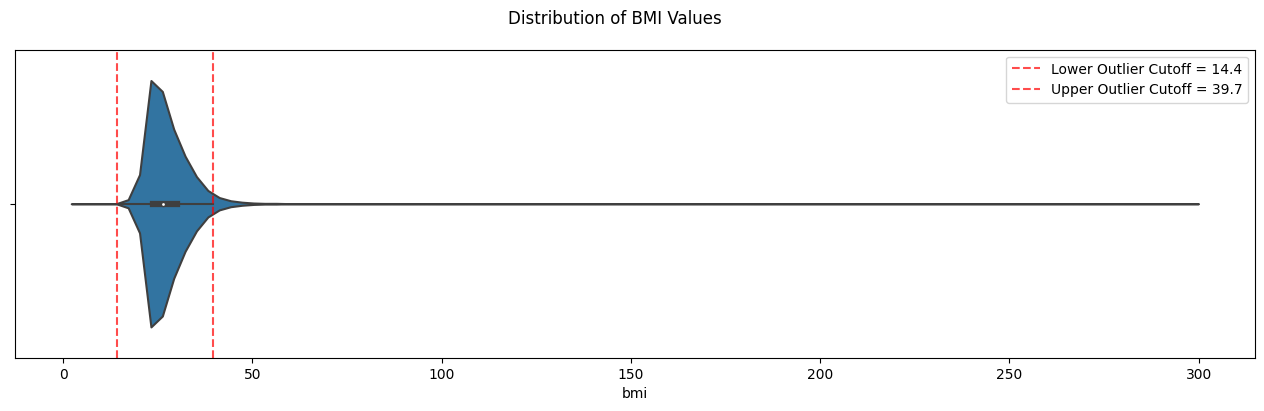

In [18]:
plt.figure(figsize = (16, 4))

sns.violinplot(x = df["bmi"])

plt.axvline(outlier_lower, color = "r", linestyle = "--", alpha = 0.7, label = f"Lower Outlier Cutoff = {outlier_lower:.1f}")
plt.axvline(outlier_upper, color = "r", linestyle = "--", alpha = 0.7, label = f"Upper Outlier Cutoff = {outlier_upper:.1f}")

plt.legend()
plt.suptitle("Distribution of BMI Values")

print(f"Amount of data cut off\nLower: {len(df[df['bmi'] < outlier_lower])}\nUpper: {len(df[df['bmi'] > outlier_upper])}")

## Outliers based on WHO cutoff points


Using WHO cutoff points: 
| | Moderate and Severe Thinness | Underweight | Normal Weight | Pre-obesity | Obesity Class I | Obesity Class II | Obesity Class III |  
| --- | --- | --- | --- | --- | --- | --- | --- |  
BMI | <17.0 | 17.0 - 18.4 | 18.5 – 24.9 | 25.0 – 29.9 | 30.0 – 34.9 | 35.0 – 39.9 | 40+ |

*sources:*  
[*Moderate and severe thinness, underweight, overweight and obesity*](https://apps.who.int/nutrition/landscape/help.aspx?menu=0&helpid=392&lang=EN#:~:text=BMI%20values%20indicate%20the%20following,BMI%2018.5%E2%80%9324.9%3A%20normal%20weight)  
[*A healthy lifestyle - WHO recommendations*](https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations)

Underweight is between 17.0 - 18.4 which is a step of 1.5  
To cut off lower outliers while still including data for Moderate and Severe Thinness, the same step of 1.5 is used  
This gives a cutoff point for lower outliers of 15.5

Obesity Class II is between 35.0 - 39.9 which is a step of 4.5  
To cut off upper outliers while still including data for Obesity Class III, the same step of 4.5 is used  
This gives a cutoff point for upper outliers at 45  

Visualised below, it gives the following cutoff points:

Amount of data cut off
Lower: 41
Upper: 605


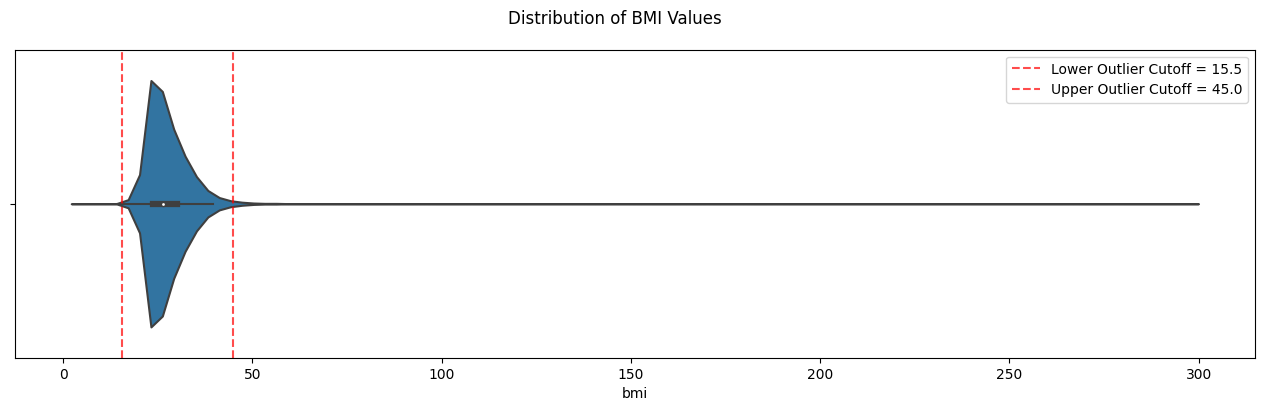

In [19]:
plt.figure(figsize = (16, 4))

sns.violinplot(x = df["bmi"])

low, high = 15.5, 45
plt.axvline(low, color = "r", linestyle = "--", alpha = 0.7, label = f"Lower Outlier Cutoff = {low:.1f}")
plt.axvline(high, color = "r", linestyle = "--", alpha = 0.7, label = f"Upper Outlier Cutoff = {high:.1f}")

plt.legend()
plt.suptitle("Distribution of BMI Values")

print(f"Amount of data cut off\nLower: {len(df[df['bmi'] < low])}\nUpper: {len(df[df['bmi'] > high])}")

# Removing BMI Outliers (2.1.0 A)

### Using outliers based on WHO cutoff points

This cuts off slightly more on the low BMI end, while keeping more of the higher BMI values compared to using Tukey's  
The result is data with at least some datapoints for each classification according to WHO standards, while removing the most extreme outlier values

In [20]:
pre = len(df)
df = df[df["bmi"].between(15.5, 45)]

print(f"{pre - len(df)} rows dropped")

df["bmi"].min(), df["bmi"].max()

646 rows dropped


(15.559636771757985, 44.997165532879826)